In [1]:
# Recurrent Neural Network Jam

In [2]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import json

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rc('legend', fontsize=18)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.constrained_layout.use'] = True
fs = (10, 6)

/opt/anaconda3/envs/aml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [126]:
# Convert an array of values into a dataset matrix:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [127]:
np.random.seed(69)

# Load data
col = [12]
file = read_csv('./Data/station_6190.csv', usecols=col,  engine='python')  # 10 pressure 12 temp
# dataset = file[:100]
dataset = file
dataset = dataset.values
dataset = dataset.astype('float32')

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split data
trainsize = int(len(dataset) * 0.67)
testsize = len(dataset) - trainsize
train, test = dataset[0:trainsize,:], dataset[trainsize:len(dataset),:]

# Reshape
lookback = 5
trainx, trainy = create_dataset(train, lookback)
testx,  testy  = create_dataset(test,  lookback)

# Reshape again
trainx = np.reshape(trainx, (trainx.shape[0], trainx.shape[1], 1))
testx  = np.reshape(testx,  (testx.shape[0],  testx.shape[1],  1))

In [128]:
trainx.shape, trainy.shape

((66691, 5, 1), (66691,))

In [129]:
# Create pytorch tensors
trainx = torch.tensor(trainx, dtype=torch.float)
trainy = torch.tensor(trainy, dtype=torch.float)

testx  = torch.tensor(testx, dtype=torch.float)
testy  = torch.tensor(testy, dtype=torch.float)

In [130]:
class Net(nn.Module):
    def __init__(self, hidden_size=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)  # Run LSTM and store the hidden layer outputs
        x = x[:, -1, :]  # take the last hidden layer
        x = self.linear(x) # a normal dense layer
        return x


net = Net()

In [131]:
opt = torch.optim.Adam(net.parameters(), lr=5e-3)
progress_bar = tqdm(range(1000))

for epoch in progress_bar:
    prediction = net(trainx)
    loss = torch.sum((prediction.flatten() - trainy.flatten())**2)
    progress_bar.set_description('Loss = {}'.format(float(loss)))
    loss.backward()
    opt.step()
    opt.zero_grad()

Loss = 14.174234390258789: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


Train Score: 0.63 RMSE
Test Score: 0.62 RMSE


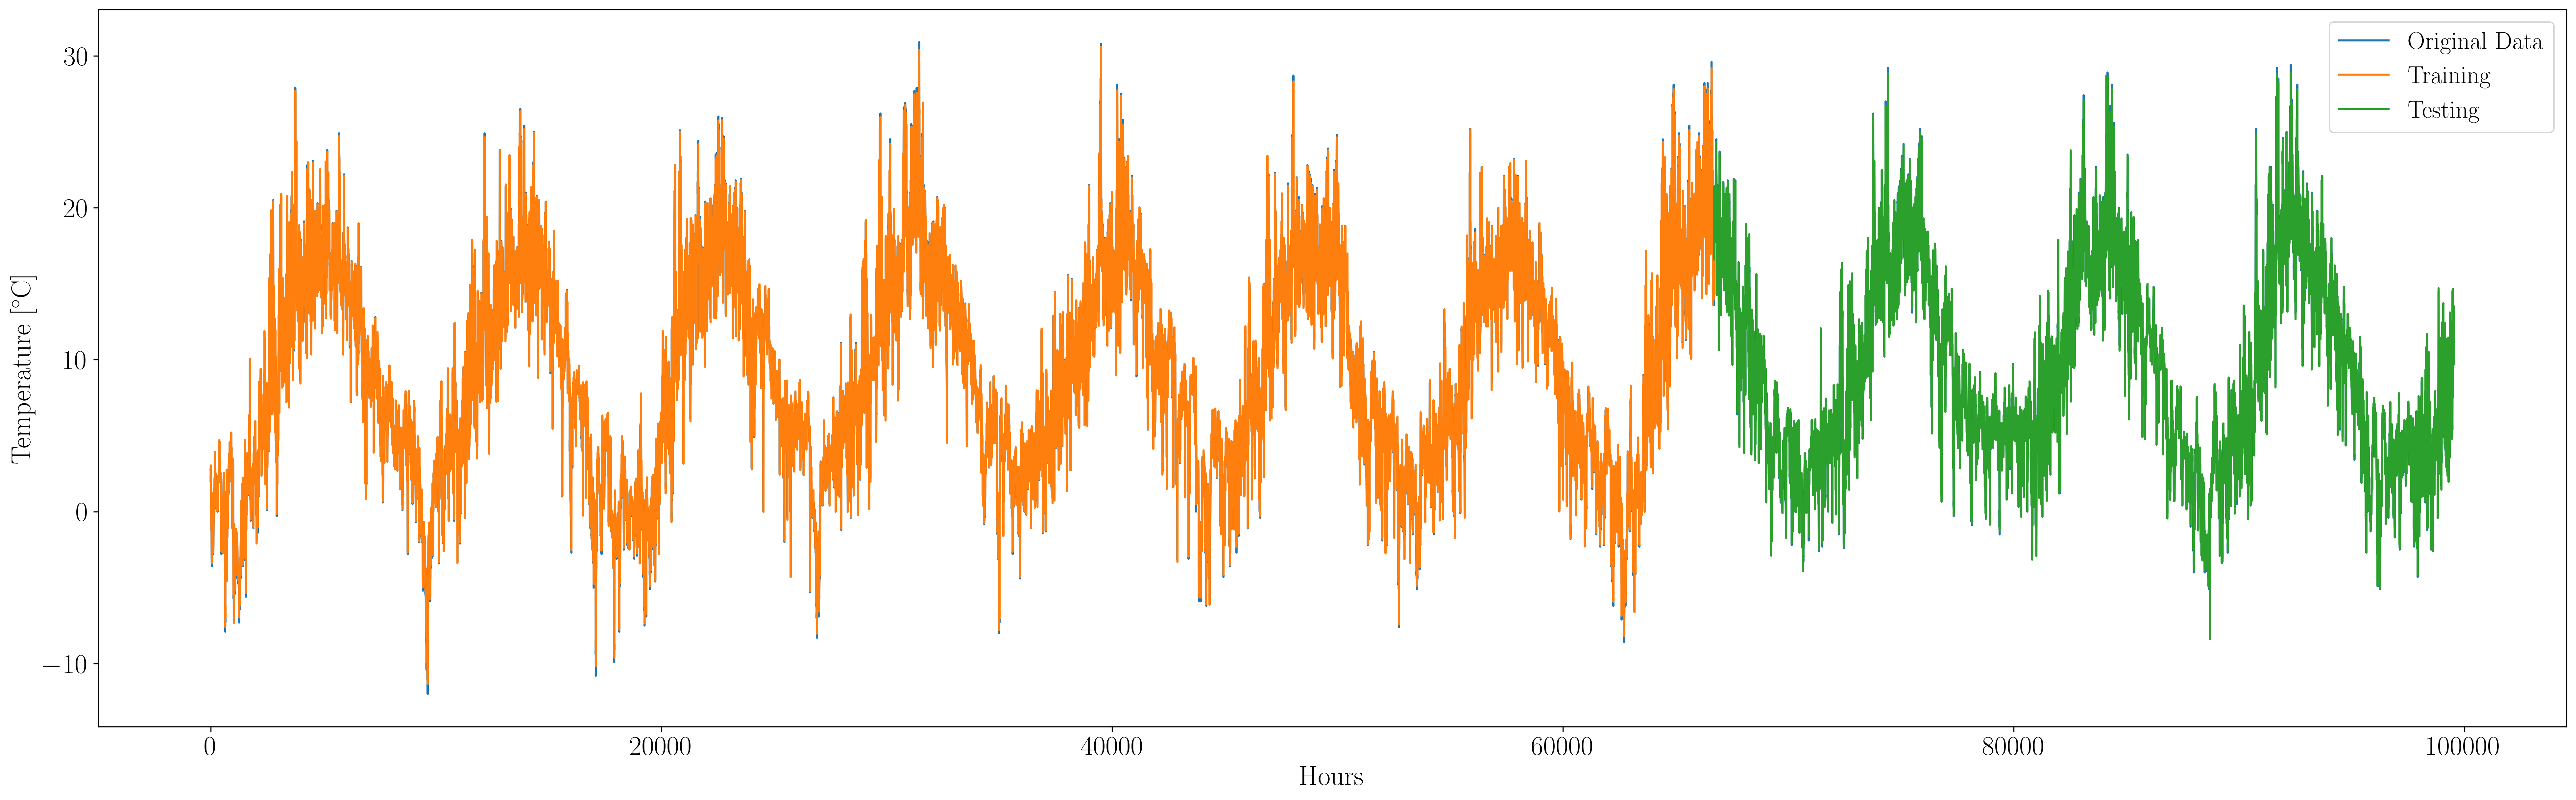

In [148]:
# make predictions
with torch.no_grad():
    trainPredict = net(trainx).numpy()
    testPredict = net(testx).numpy()

look_back = lookback


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainy_inv = scaler.inverse_transform([trainy.numpy()])
testPredict = scaler.inverse_transform(testPredict)
testy_inv = scaler.inverse_transform([testy.numpy()])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainy_inv[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testy_inv[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(26,8))
plt.plot(scaler.inverse_transform(dataset), label=r'Original Data')
plt.plot(trainPredictPlot, label=r'Training')
plt.plot(testPredictPlot, label=r'Testing')
if col == [12]:
    plt.ylabel(r'Temperature [$^{\circ}$C]')
elif col == [10]:
    plt.ylabel(r'Pressure [idk]')
else:
    print('error')
plt.xlabel(r'Hours')
# plt.xlim([60000, 80000])
plt.legend()
plt.show()

#### __Predict Using Model__

In [145]:
# testing
example = np.array([12.2, 12.4, 12.4, 12.5, 12.5])
example = np.reshape(example, (5, 1))
example = scaler.transform(example)
example = np.reshape(example, (1, 5, 1))
example = torch.tensor(example, dtype=torch.float)
# make predictions
with torch.no_grad():
    predict = net(example).numpy()

predict = scaler.inverse_transform(predict)
# score 
print(np.float16(predict))

[[12.51]]


## __Better Model Hopefully__

In [117]:
# ta/station_6190.csv', usecols=np.arange(7, 17), engine='python')
# file = np.array(file)
# # file = np.reshape(file, (file.shape[0], file.shape[1], 1))
# print(file.shape)
# scaler = MinMaxScaler(feature_range=(0, 1))
# data = scaler.fit_transform(file)file = read_csv('./Da

file = pd.read_csv('./Data/station_6190.csv')
time = file['hour']
file = file.drop(['year', 'month', 'day', 'hour', 'stationId', 'latitude', 'longitude', 'min_temp', 'max_temp_w_date'], axis=1)
# file = file.head()
data = file.copy()
print(file.shape)

slice = np.array(data)[0, :]
# print(slice)
noise = np.random.normal(loc=0, scale=10, size=slice.shape)
empty = np.zeros(data.shape)
print(empty[0:2, :])
empty[0, :] = noise
print(empty[0:2, :])
new = np.array(data) + empty
new[:, -1] = 0
# print(new[0, :])
noisy = pd.DataFrame(new, columns=data.columns)
# noise = np.random.normal(loc=0, scale=1, size=file.shape)
# noisy = np.array(data) + noise
# noisy = pd.DataFrame(noisy, columns=file.columns)
print(noisy.shape)
# noisy = pd.DataFrame(noisy)

maxfeatrange = 5

scaler = MinMaxScaler(feature_range=(0, maxfeatrange))

scalers = []
scalern = []

realscale = MinMaxScaler(feature_range=(0, maxfeatrange)).fit(np.array(file['mean_temp']).reshape(-1, 1))
noisescale = MinMaxScaler(feature_range=(0, maxfeatrange)).fit(np.array(noisy['mean_temp']).reshape(-1, 1))

for i in range(len(file.columns)):
    scaler.fit(np.array(file[file.columns[i]]).reshape(-1, 1))
    data[data.columns[i]]  = scaler.transform(np.array(file[file.columns[i]]).reshape(-1, 1))
    scalers.append(scaler)
    scaler.fit(np.array(noisy[file.columns[i]]).reshape(-1, 1))
    noisy[data.columns[i]] = scaler.transform(np.array(file[file.columns[i]]).reshape(-1, 1))
    scalern.append(scaler)

# data = scaler.fit_transform(file)
# data = np.array(file)
# data = file.copy()

(99548, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[ -6.06096439  -5.80025931 -17.12379164  -8.8558041   -2.91676449
    6.58400804  -6.46691173   4.93607498]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]]
(99548, 8)


In [118]:
data.head(5)

,max_wind_speed_10min,max_wind_speed_3sec,mean_pressure,mean_relative_hum,mean_temp,mean_wind_dir,mean_wind_speed,vapour_pressure_deficit_mean
0,3.733032,3.537313,2.308161,4.86,1.631702,3.486111,3.598131,0.0
1,3.959276,3.537313,2.168088,4.84,1.666667,3.513889,3.995327,0.0
2,3.959276,3.462687,2.052375,4.89,1.678322,3.527778,3.995327,0.0
3,3.846154,3.388060,1.985384,4.84,1.713287,3.597222,3.925234,0.0
4,4.185520,3.686567,1.948843,4.79,1.736597,3.750000,3.714953,0.0


In [119]:
noisy.head(5)

,max_wind_speed_10min,max_wind_speed_3sec,mean_pressure,mean_relative_hum,mean_temp,mean_wind_dir,mean_wind_speed,vapour_pressure_deficit_mean
0,3.733032,3.537313,2.308161,4.86,1.631702,3.486111,3.598131,0.0
1,3.959276,3.537313,2.168088,4.84,1.666667,3.513889,3.995327,0.0
2,3.959276,3.462687,2.052375,4.89,1.678322,3.527778,3.995327,0.0
3,3.846154,3.388060,1.985384,4.84,1.713287,3.597222,3.925234,0.0
4,4.185520,3.686567,1.948843,4.79,1.736597,3.750000,3.714953,0.0


In [120]:
print(np.mean(np.abs(data - noisy)))

max_wind_speed_10min            0.000000
max_wind_speed_3sec             0.000000
mean_pressure                   0.000000
mean_relative_hum               0.000000
mean_temp                       0.000000
mean_wind_dir                   0.000000
mean_wind_speed                 0.000000
vapour_pressure_deficit_mean    0.819348
dtype: float64


/opt/anaconda3/envs/aml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [121]:
sequence_length  = 50
forecast_horizon = 5

series_x = []
series_y = []

noisex = []
noisey = []

for t in range(sequence_length, (len(data)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
    series_x.append(np.array(data[data.columns][(t - sequence_length):t])) # here we select the time and the measurement from the past t-sequence_length observations
    series_y.append(data['mean_temp'][t+forecast_horizon])# here we select the observed measurement at t+forecast_horizon in the future
    noisex.append(np.array(noisy[noisy.columns][(t - sequence_length):t]))
    noisey.append(noisy['mean_temp'][t+forecast_horizon])

# for t in range(sequence_length,(len(data)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
#     series_x.append(np.array(data[['mean_temp', 'mean_pressure']][(t - sequence_length):t])) # here we select the time and the measurement from the past t-sequence_length observations
#     series_y.append(data['mean_temp'][t+forecast_horizon])# here we select the observed measurement at t+forecast_horizon in the future

series_x = np.array(series_x)
series_y = np.array(series_y)

noisex = np.array(noisex)
noisey = np.array(noisey)

print('dimensions of input:')
print(series_x.shape)
print(noisex.shape)
print('-------------')
print('dimension of truth:')
print(series_y.shape)
print(noisey.shape)
print('-------------')
print('total number of time steps in data:')
print((len(data)))
print((len(noisy)))

dimensions of input:
(99493, 50, 8)
(99493, 50, 8)
-------------
dimension of truth:
(99493,)
(99493,)
-------------
total number of time steps in data:
99548
99548


In [85]:
# just for noise
noisex = []
noisey = []

for t in range(sequence_length, (len(data)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
    noisex.append(np.array(noisy[noisy.columns][(t - sequence_length):t]))
    noisey.append(noisy['mean_temp'][t+forecast_horizon])

noisex = np.array(noisex)
noisey = np.array(noisey)

In [122]:
xtrain, xvalid, ytrain, yvalid = train_test_split(series_x, series_y, test_size=0.3, random_state=69)
xtrainno, xvalidnoise, ytrainno, yvalidno = train_test_split(noisex, noisey, test_size=0.3, random_state=69)

In [123]:
xvalid.shape, xvalidnoise.shape

((29848, 50, 8), (29848, 50, 8))

In [124]:
tsinputs = tf.keras.Input(shape=(sequence_length, len(file.columns)))

x = layers.LSTM(units=10)(tsinputs)
x = layers.Dropout(0.01)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=tsinputs, outputs=outputs)

In [125]:
learningrate = 1e-3
nepochs = 15
batchsize = 50
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=learningrate),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mse'])
history = model.fit(x=xtrain, y=ytrain, batch_size=batchsize, validation_data=(xvalid, yvalid), epochs=nepochs)

Epoch 1/15
1393/1393 [==============================] - 31s 21ms/step - loss: 0.3474 - mse: 0.3474 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 2/15
1393/1393 [==============================] - 29s 21ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 3/15
1393/1393 [==============================] - 25s 18ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 4/15
1393/1393 [==============================] - 27s 19ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 5/15
1393/1393 [==============================] - 27s 20ms/step - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 6/15
1393/1393 [==============================] - 28s 20ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 7/15
1393/1393 [==============================] - 25s 18ms/step - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 8/15
1393/1393 [==========================

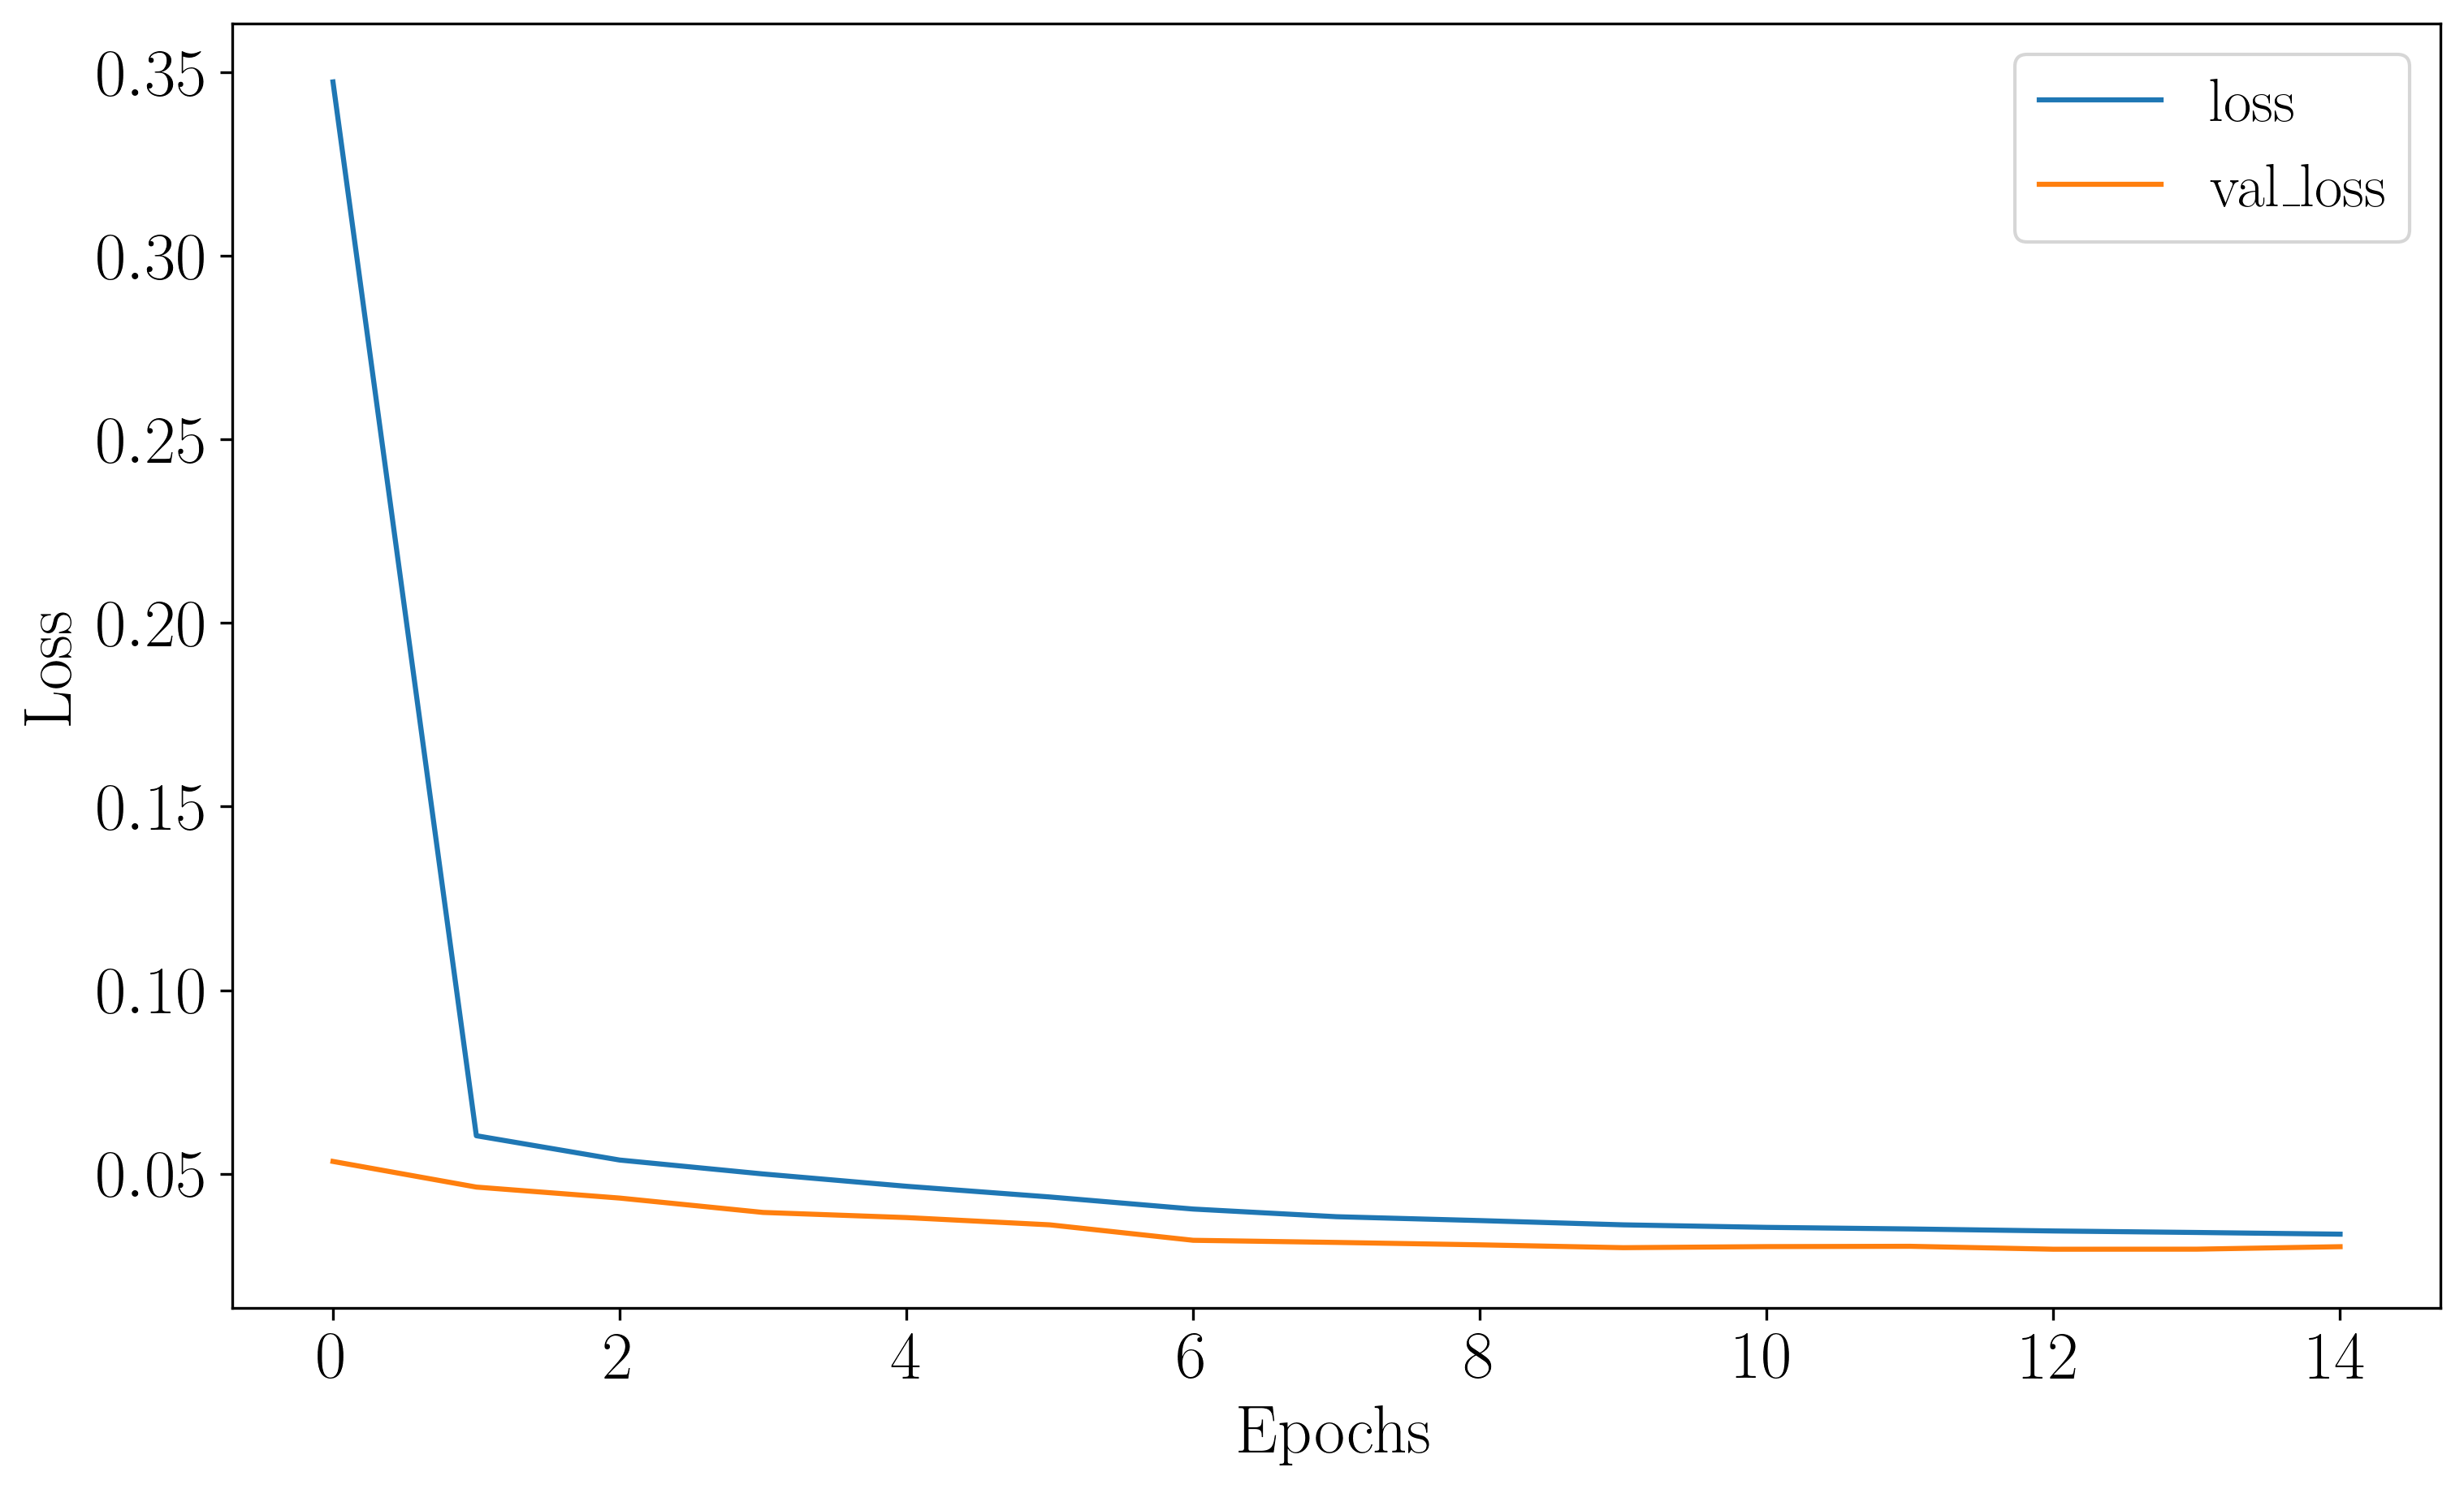

In [126]:
loss = history.history['loss']
valloss = history.history['val_loss']
epochs = np.arange(len(loss))

plt.figure(figsize=fs)
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, valloss, label='val_loss')
plt.xlabel(r'Epochs')
plt.ylabel(r'Loss')
plt.legend()
plt.show()

In [127]:
xvalid.shape

(29848, 50, 8)

In [128]:
predictions = model.predict(x=xvalid)

# noiseval = np.random.normal(loc=0, scale=0.000001, size=xvalid.shape)
# noiseval = np.zeros(xvalid.shape)
# noiseval[0, 0, 4] = 50
# xnoise = xvalid + noiseval

prednoise = model.predict(x=xvalidnoise)
# prednoise = model.predict(x=xnoise)

# pred = scalers[4].inverse_transform(predictions)
predr = realscale.inverse_transform(predictions)
predrn = noisescale.inverse_transform(prednoise)
# yinv = scalers[4].inverse_transform(yvalid.reshape(-1, 1))
yinvr = realscale.inverse_transform(yvalid.reshape(-1, 1))

# tpred = model.predict(x=xtrain)
# tpred = scalers[4].inverse_transform(tpred)
# tyinv = scalers[4].inverse_transform(ytrain.reshape(-1, 1))

In [97]:
prednoise = model.predict(x=xvalidnoise)
predrn = noisescale.inverse_transform(prednoise)

In [129]:
predictions.shape, prednoise.shape, yvalid.shape

((29848, 1), (29848, 1), (29848,))

In [130]:
traintime, testtime = train_test_split(time, test_size=0.3)

Noise Score:		9.983322 RMSE
No Noise  Score:	10.204718 RMSE

Average % Error on Predictions	6.00084


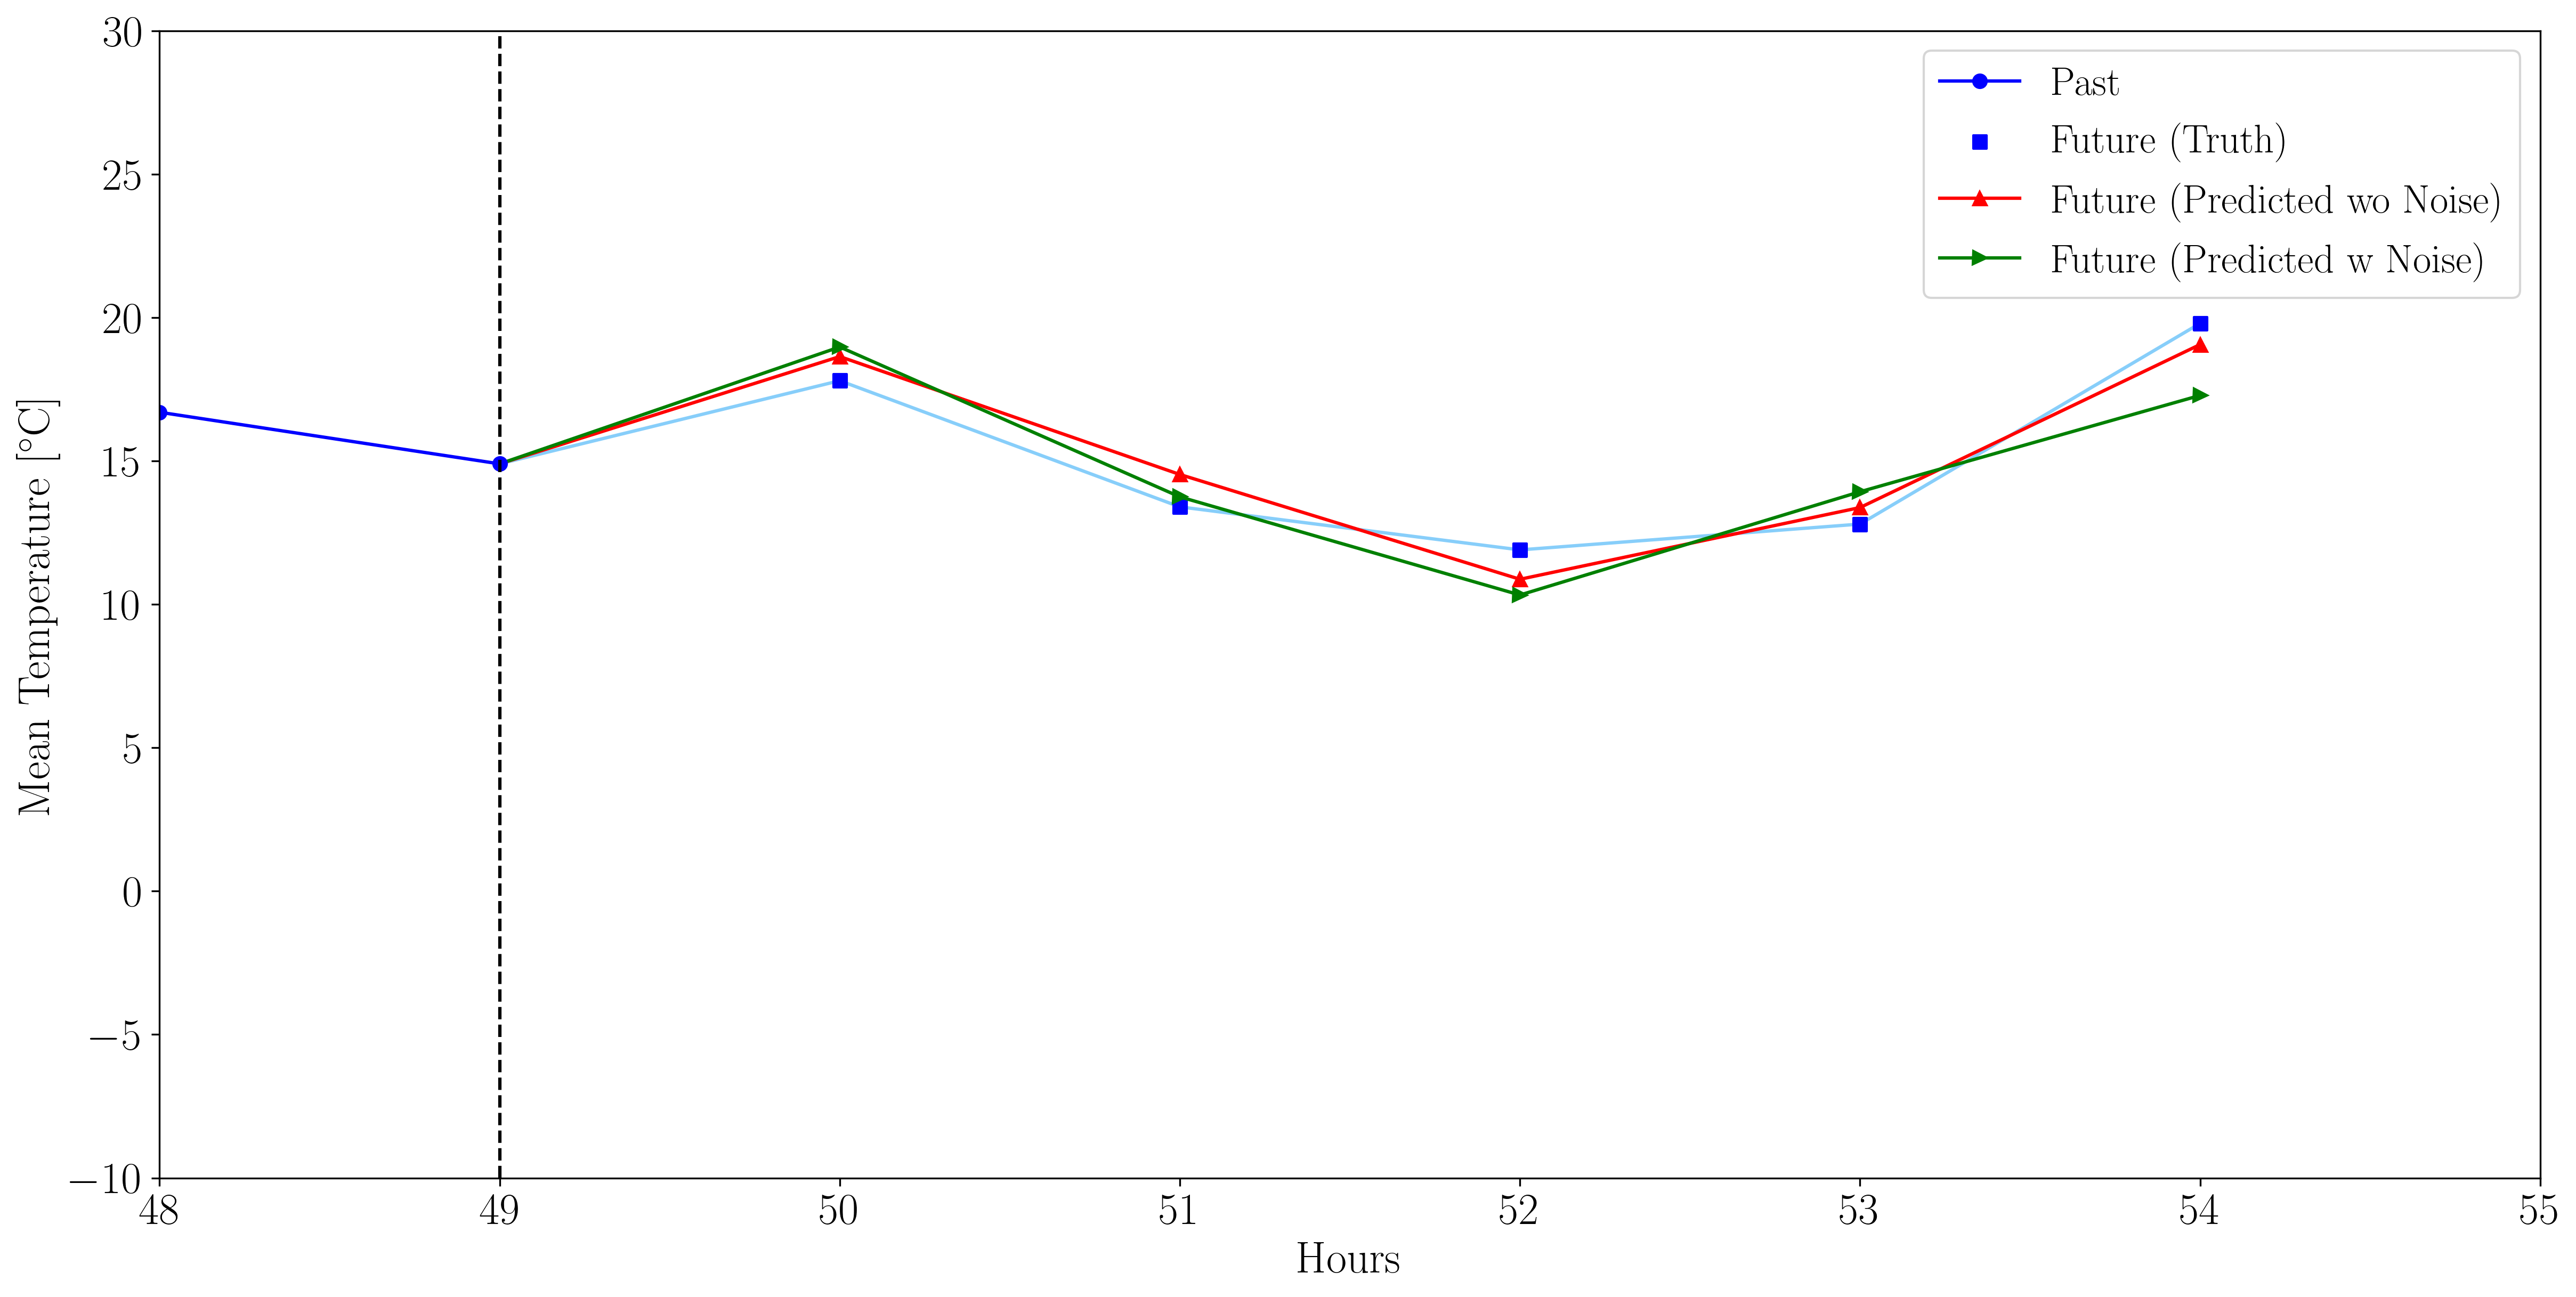

In [133]:
noise = math.sqrt(mean_squared_error(yinv, predrn))
nonoise = math.sqrt(mean_squared_error(yinv, predr))
print('Noise Score:\t\t%.6f RMSE' % (noise))
print('No Noise  Score:\t%.6f RMSE' % (nonoise))

print()

# s = int(len(pred) * 0.01)
s = 1

scaledpred = predr[50:55]
scaledpredn = predrn[50:55]
# scaledyinv = yinv[::s]
scaledyinv = yinvr[:55]
# scaledtpred = tpred[::s]
# scaledtyinv = tyinv[::s]

print('Average % Error on Predictions\t{:.5f}'.format(np.mean(np.abs(scaledpred - scaledyinv[50:]) / scaledyinv[50:] * 100)))

plt.figure(figsize=(16, 8))
plt.plot(np.arange(50), scaledyinv[:50], label=r'Past', c='b', marker='o')
plt.plot(np.arange(50, 55), scaledyinv[50:], c='lightskyblue')
plt.scatter(np.arange(50, 55), scaledyinv[50:], label=r'Future (Truth)', c='b', marker='s', zorder=10)
plt.plot(np.arange(50, 55), scaledpred, label=r'Future (Predicted wo Noise)', c='r', marker='^', zorder=10)
plt.plot(np.arange(50, 55), scaledpredn, label=r'Future (Predicted w Noise)', c='g', marker='>', zorder=10)
plt.plot([49, 50], [scaledyinv[-6], scaledyinv[-5]], c='lightskyblue', zorder=1)
plt.plot([49, 50], [scaledyinv[-6], scaledpred[0]], c='r', zorder=1)
plt.plot([49, 50], [scaledyinv[-6], scaledpredn[0]], c='g', zorder=1)
plt.plot([49, 49], [-10, 30], c='k', ls='--')
# plt.text(x=45, y=-5, s=r'Past')
# plt.text(x=51.5, y=-5, s=r'Future')
plt.legend()
plt.ylim(-10, 30)
plt.xlim(48, 55)
plt.xlabel(r'Hours')
plt.ylabel(r'Mean Temperature [$^{\circ}$C]')
plt.show()

### __Test on Some Recent Data__

In [127]:
v = np.array([12.7, 12.4, 12.0, 11.8, 12.2, 12.5, 12.9, 13.3, 14.1, 15.1])
v.shape

(10,)

In [26]:
testing = data.tail(sequence_length + forecast_horizon)
testingx = testing[:sequence_length]
testingy = testing[sequence_length:]
testingy = testingy['mean_temp']

# xtest = []
# ytest = []

# for t in range(sequence_length, (len(testing)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
#     xtest.append(np.array(data[data.columns][(t - sequence_length):t])) # here we select the time and the measurement from the past t-sequence_length observations
#     ytest.append(data['mean_temp'][t+forecast_horizon])
# # put testing data into this format then run it

# xtest = np.array(xtest)
# ytest = np.array(ytest)

# print(xtest.shape, ytest.shape)

testingx = np.array(testingx)
testscale = MinMaxScaler()
testingx = testscale.fit_transform(testingx)
testingx = np.reshape(testingx, (1, len(testingx), len(data.columns)))
print(testingx.shape, testingy.shape)


predictions1 = model.predict(x=testingx)
print(predictions1.shape)

pred = testscale.inverse_transform(predictions1)
# yinv = scalers[4].inverse_transform(testingx.reshape(-1, 1))


(1, 50, 8) (5,)
(1, 1)


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,8)

In [28]:
pred.shape, yinv.shape

((1, 1), (400, 1))

In [29]:
print(pred)

[[1.6141458]]


In [1]:
0.091936**2

0.008452228096